## Configure environment

In [1]:
#!pip install -U --quiet langgraph langsmith langchain_openai

In [2]:
SYSTEM_PROMPT = """Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. This screenshot will
feature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual
information to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow
the guidelines and choose one of the following actions:

1. Click a Web Element.
2. Delete existing content in a textbox and then type content.
3. Scroll up or down.
4. Wait 
5. Go back
7. Return to google to start over.
8. Respond with the final answer

Correspondingly, Action should STRICTLY follow the format:

- Click [Numerical_Label] 
- Type [Numerical_Label]; [Content] 
- Scroll [Numerical_Label or WINDOW]; [up or down] 
- Wait 
- GoBack
- Google
- ANSWER; [content]

Key Guidelines You MUST follow:

* Action guidelines *
1) Execute only one action per iteration.
2) When clicking or typing, ensure to select the correct bounding box.
3) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.

* Web Browsing Guidelines *
1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
2) Select strategically to minimize time wasted.

Your reply should strictly follow the format:

Thought: {{Your brief thoughts (briefly summarize the info that will help ANSWER)}}
Action: {{One Action format you choose}}
Then the User will provide:
Observation: {{A labeled screenshot Given by User}}
"""

In [3]:
# Add tracing to visualize agent directories
import os
from getpass import getpass

def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"
_getpass("OPENAI_API_KEY")
_getpass("LANGCHAIN_API_KEY")

OPENAI_API_KEY= ········
LANGCHAIN_API_KEY= ········


## Install agent requirements

In [16]:
#!pip install --upgrade --quiet playwright
#!playwright install  

In [5]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Define graph state

The state provides the input to each node in the graph

The agent will track webpage object, annotated images and bounding boxes, user's initial request, and the messages containing scratchpad, system prompt, and other information.

In [6]:
from typing import List, Optional, TypedDict
from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page

# Create a BBox class(x, y, text, type, ariaLabel)
class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str
    
# Create prediction class (action, args)
class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]

# Create agent state(page, input, img, bboxes, prediction, scratchpad, & observation)
# This represents agent state as it proceeds through execution
class AgentState(TypedDict):
    page: Page # The playwright webpage that helps the agent interact with the web environment
    input: str # The user request
    img: str # Base64 encoded screenshot
    bboxes: List[BBox] # The bounding boxes sorrounding webpage elements that the agent will interact with
    prediction: Prediction # The agents output
    # The system message(s) that serve as intermediate steps(thought and actions to be performed)
    scratchpad: List[BaseMessage] 
    observation: str # The most recent response from a tool
    

## Define tools

The agent has 6 simple tools:

1. Click (at labelled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google search)

We define them here below as functions.

In [7]:
import asyncio
import platform

# Create a click function that handles clicking elements on the webpage
# 1. We grab the page from agent state, then grab the bounding box ID from prediction state.
# 2. We then grab the bounding box based on its ID, extract the x & y coordinates of the element on the page and finally
# 3. We Click the required element based on the x & y values.
async def click(state: AgentState):
    # Click - [Numerical_label]
    page = state["page"]
    click_args = state["prediction"]["args"]

    if not click_args and len(click_args) != 1:
        return f"Failed to click bounding box labelled as number: {click_args}"
    bbox_id = int(click_args[0])
    try:
        bbox = state["bboxes"][bbox_id]
    except:
        return f"Failed to get box(element) with ID: {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    res = await page.mouse.click(x, y)

    return f"Clicked on box(element) with ID: {bbox_id}"
    
# Create function for typing text into webpage inputs
# 1. We grab the page, then grab the [bounding_box_id, content] from prediction state
# 2. We the extract x & y coordinates for the input element to be acted on
# 3. Subsequently, we click and highlight on all text(if exist) in the element and delete them
# 4. Finally, we can then input the content into the input element
async def type_text(state: AgentState):
    # Type - [Numerical_label, content]
    page = state["page"]
    typing_args = state["prediction"]["args"]

    if not typing_args and len(typing_args) != 2:
        return f"Failed to type content in input box(element) with props: {typing_args}"

    bbox_id = int(typing_args[0])
    text_content = typing_args[1]
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    # Check if MacOS
    select_all_command = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.mouse.click(x, y)
    await page.keyboard.press(select_all_command)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")

    return f"Typed {text_content} in the box(element) with ID: {bbox_id}"
    
# Create a function to scroll up/down a webpage
# 1. Grab the page, then get [target, direction] from args prop of prediction state
# 2. if target is WINDOW, set scroll_amount and scroll_direction and scroll based on those information
# 3. Otherwise, target is a bounding_box_id and so we scroll within the element with scroll amount and direction
async def scroll(state: AgentState):
    # Type - [target(Window or bbox_id), direction]
    page = state["page"]
    scroll_args = state["prediction"]["args"]

    if not scroll_args and len(scroll_args) != 2:
        return f"Failed to scroll due to incorrect arguments"

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure this is the best value
        scroll_amount = 500
        scroll_amount_based_on_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_amount_based_on_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbbox["x"], bbox["y"]
        scoll_amount_based_on_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_amount_based_on_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"
# Create a function for waiting based on interactions on the webpage
async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s"
    
# Create a function for going back on a page
async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back to a page to {page.url}"
    
# Create a function for using the google searcg engine
async def to_google():
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com"
    

## Define agent

The agent is driven by a multimodal model and decides the action to take for each step.It is composed of a few runnables.

1. A `mark_page` function to annotate elements in the web page with bounding boxes.
2. A prompt to hold user question, annotated image and agent scratchpad
3. GPT-4V to decide next steps
4. Parsing logic to extract the action

Let's first define the annotation step:

__Browser Annotations__

This function annotates all buttons, inputs, text areas, etc. with numbered bounding boxes. GPT-4V then just has to refer to bounding box when taking actions, reducing the complexity of the overall task.

In [8]:
import asyncio
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript will run on each step to take a screenshot of the page
# and then select the elements to annotate and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()

@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes
    }

## Agent definition

Now we will compose this function with `prompt`, `llm`, `output parser` to complete our agent.

In [9]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

async def annotate(state: AgentState):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}

def format_descriptions(state: AgentState):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox.get("text")
        el_type = bbox.get("type")
        labels.append(f"{i} (<{el_type} />): '{text}'")
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}

def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}
    
# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

In [10]:
llm = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=4096)
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

## Define graph

We've created most of the important logic. We have one more function to define, this will update the graph state after a tool is called:

In [11]:
import re

def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update the scratchpad so the agent is aware
    of its previous steps
    """
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

Now we can compose everything into a graph:

In [13]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph

graph_builder = StateGraph(AgentState)

graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google
}

for node_name, node_tool in tools.items():

    # Runnable lambda helps map the string from node tool to observation key in agent state
    graph_builder.add_node(
        node_name,
        RunnableLambda(node_tool) | (lambda observation: {"observation": observation})
    )
    # Always return to agent through update_scratchpad
    graph_builder.add_edge(node_name, "update_scratchpad")

def select_tool(state: AgentState):
    # After the agent completes, it can either route
    # to itself, end user or a tool
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    elif action == "retry":
        return "agent"
    else:
        return action

graph_builder.add_conditional_edges("agent", select_tool)

web_agent = graph_builder.compile()

## Run agent

Now that we have created the whole executor, we can run it on a few questions. We'll start our browser at __"google.com"__ and then let it control the rest.

Below is a helper function to help print out the steps to the notebook (and display the intermediate screenshots).

In [19]:
import playwright
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")

async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = web_agent.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps
        }
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer
    

1. Type: ['7', 'WebVoyager paper arxiv']
2. Click: ['15']
3. ANSWER;: ['"WebVoyager: Building an End-to-End Web Agent with Large Multimodal Models" is a research paper that discusses the creation and implementation of an innovative web agent called WebVoyager. This agent is powered by Large Multimodal Models (LLMs) and is capable of completing user instructions end-to-end by interacting with real-world websites. The paper highlights the challenges faced by existing web agents, which are usually limited to a single input modality and cannot operate effectively in real-world scenarios. To overcome these limitations, WebVoyager integrates a benchmark that compiles tasks from 15 popular websites and uses an automatic evaluation protocol with multimodal understanding abilities of GPT-4 to evaluate open-ended web agents. The results show that WebVoyager has a 59.1% task success rate on their benchmark, significantly outperforming GPT-4 in both all-tools and text-only setups. The proposed aut

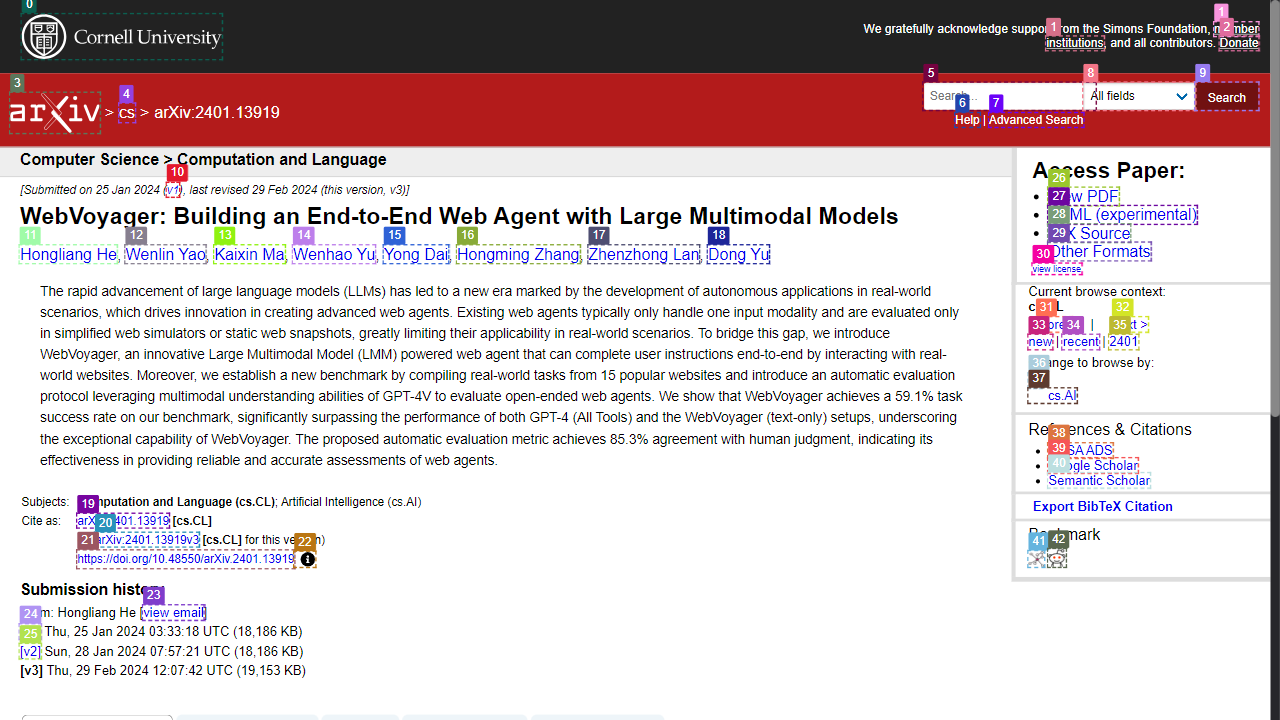

Final response: "WebVoyager: Building an End-to-End Web Agent with Large Multimodal Models" is a research paper that discusses the creation and implementation of an innovative web agent called WebVoyager. This agent is powered by Large Multimodal Models (LLMs) and is capable of completing user instructions end-to-end by interacting with real-world websites. The paper highlights the challenges faced by existing web agents, which are usually limited to a single input modality and cannot operate effectively in real-world scenarios. To overcome these limitations, WebVoyager integrates a benchmark that compiles tasks from 15 popular websites and uses an automatic evaluation protocol with multimodal understanding abilities of GPT-4 to evaluate open-ended web agents. The results show that WebVoyager has a 59.1% task success rate on their benchmark, significantly outperforming GPT-4 in both all-tools and text-only setups. The proposed automatic evaluation metric has an 85.3% agreement with hum

In [20]:
res = await call_agent("Could you explain the WebVoyager paper (on arxiv)?", page)
print(f"Final response: {res}")